In [ ]:
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
from tqdm.keras import TqdmCallback
from skimage import transform
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization, Conv2D,MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/chest_xray'
train_path='/content/drive/MyDrive/chest_xray /train'
test_path='/content/drive/MyDrive/chest_xray /test'

#Numeric Constants.
batch_size=32
img_width=299
img_height=299

In [ ]:
# generators
train = keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(299,299)
)

test = keras.utils.image_dataset_from_directory(
    directory = test_path,
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(299,299)
)

Found 4750 files belonging to 3 classes.
Found 1188 files belonging to 3 classes.


In [ ]:
class_names=train.class_names
print(f"Our target classes are :{class_names}")

Our target classes are :['NORMAL', 'PNEUMONIA_BACTERIAL', 'PNEUMONIA_VIRAL']


In [ ]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train = train.map(process)
test = test.map(process)

**XCEPTION MODEL**


In [ ]:
# prompt: generate xception model

base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(img_width, img_height, 3),
    include_top=False
)
num_classes=len(class_names)
base_model.trainable = False
model_ex = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(num_classes)
])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_ex.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

NUM_EPOCHS=13

In [ ]:
history=model_ex.fit(
    train,
    validation_data=test,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping,TqdmCallback(verbose=0)],
    verbose=1
)

0epoch [00:00, ?epoch/s]

Epoch 1/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - acc: 0.6776 - loss: 0.7691 - val_acc: 0.7971 - val_loss: 0.5349
Epoch 2/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 359ms/step - acc: 0.7819 - loss: 0.5436 - val_acc: 0.7921 - val_loss: 0.5045
Epoch 3/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 64s 427ms/step - acc: 0.7903 - loss: 0.5169 - val_acc: 0.7963 - val_loss: 0.4929
Epoch 4/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 360ms/step - acc: 0.7966 - loss: 0.4892 - val_acc: 0.7963 - val_loss: 0.4840
Epoch 5/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 83s 365ms/step - acc: 0.8117 - loss: 0.4697 - val_acc: 0.7997 - val_loss: 0.4733
Epoch 6/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 82s 364ms/step - acc: 0.8103 - loss: 0.4626 - val_acc: 0.8089 - val_loss: 0.4641
Epoch 7/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 361ms/step - acc: 0.8117 - loss: 0.4484 - val_acc: 0.8157 - val_loss: 0.4607
Epoch 8/13
149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 362ms/step - acc: 0.8225 - loss: 0.4439 - val_acc: 0.8013 - val_loss: 0.4679
Epoch 9/13
149/149 ━━━━━━━━━━━━━━━

In [ ]:
# Saving the model with the correct extension
model_ex.save('/content/drive/MyDrive/model_ex.keras')

# Loading the model with the correct extension
model_ex = tf.keras.models.load_model('/content/drive/MyDrive/model_ex.keras')

In [ ]:
model_acc='{:.2%}'.format(history.history['acc'][-1])
print(f"\n Our Model Accuracy Reached: {model_acc}")


 Our Model Accuracy Reached: 83.75%


In [ ]:
# prompt: evaluate test set and find accuracy

loss, accuracy = model_ex.evaluate(test)
print('Test accuracy :', accuracy*100)


38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 326ms/step - acc: 0.8207 - loss: 0.4347
Test accuracy : 81.56565427780151


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Get the predictions for the test data
predictions = model_ex.predict(test)

# Convert the predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Extract the true labels from the test dataset
true_labels = np.concatenate([y for x, y in test], axis=0)  # Assuming 'y' represents the labels in your dataset

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step
Confusion Matrix:
[[ 66 191  68]
 [168 278 118]
 [ 98 143  58]]


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Get the predictions for the test data
predictions = model_ex.predict(test)

# Convert the predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Extract the true labels from the test dataset
true_labels = np.concatenate([y for x, y in test], axis=0)  # Assuming 'y' represents the labels in your dataset

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 377ms/step
Confusion Matrix:
[[ 93 165  67]
 [156 295 113]
 [ 83 152  64]]


In [ ]:
# prompt: save model_ex to folder in drive

# Adding the .keras extension to the file path
model_ex.save('/content/drive/MyDrive/model_ex.keras')

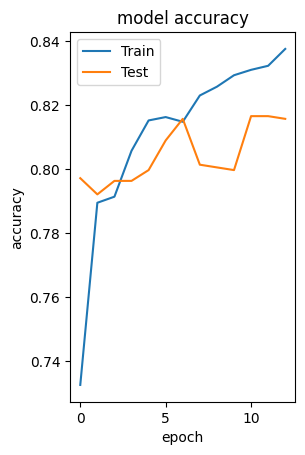

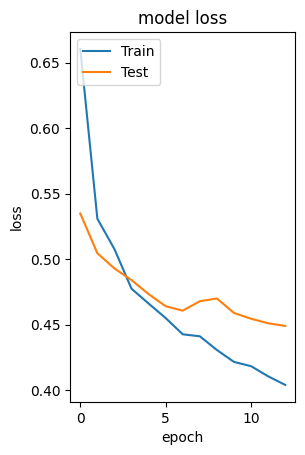

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
The Predicted Class: PNEUMONIA_BACTERIAL



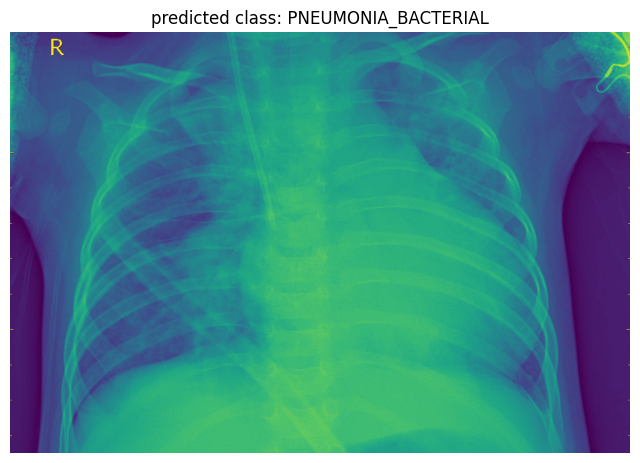

In [ ]:
test_img_path = '/content/drive/MyDrive/chest_xray /test/PNEUMONIA_BACTERIAL/person1031_bacteria_2963.jpeg'
test_image = Image.open(test_img_path)
test_image = np.array(test_image).astype('float32')/255
test_image = transform.resize(test_image, (img_width, img_height, 3))
test_image = np.expand_dims(test_image, axis=0)

prediction = model_ex.predict(test_image)
pred_class = prediction.argmax()
print(f"The Predicted Class: {class_names[pred_class]}\n")

plt.figure(figsize=(8,8))
test_img = mpimg.imread(test_img_path)
plt.imshow(test_img)
plt.title("predicted class: "+class_names[pred_class])
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
The Predicted Class: PNEUMONIA_VIRAL



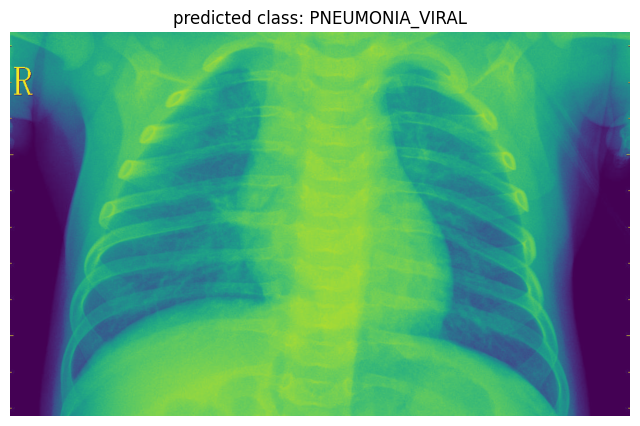

In [ ]:
test_img_path = "/content/drive/MyDrive/chest_xray /test/PNEUMONIA_VIRAL/person1111_virus_1836.jpeg"
test_image = Image.open(test_img_path)
test_image = np.array(test_image).astype('float32')/255
test_image = transform.resize(test_image, (img_width, img_height, 3))
test_image = np.expand_dims(test_image, axis=0)

prediction = model_ex.predict(test_image)
pred_class = prediction.argmax()
print(f"The Predicted Class: {class_names[pred_class]}\n")

plt.figure(figsize=(8,8))
test_img = mpimg.imread(test_img_path)
plt.imshow(test_img)
plt.title("predicted class: "+class_names[pred_class])
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
The Predicted Class: NORMAL



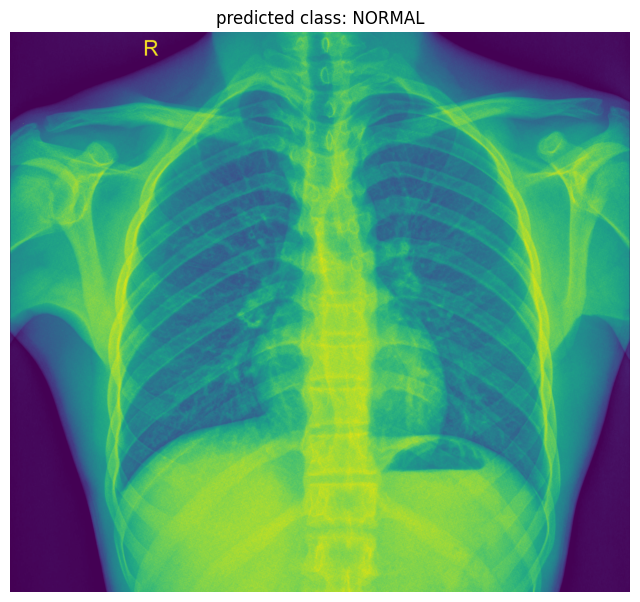

In [ ]:
test_img_path = "/content/drive/MyDrive/chest_xray /test/NORMAL/IM-0025-0001.jpeg"
test_image = Image.open(test_img_path)
test_image = np.array(test_image).astype('float32')/255
test_image = transform.resize(test_image, (img_width, img_height, 3))
test_image = np.expand_dims(test_image, axis=0)

prediction = model_ex.predict(test_image)
pred_class = prediction.argmax()
print(f"The Predicted Class: {class_names[pred_class]}\n")

plt.figure(figsize=(8,8))
test_img = mpimg.imread(test_img_path)
plt.imshow(test_img)
plt.title("predicted class: "+class_names[pred_class])
plt.axis('off')
plt.show()

In [ ]:
!pip install tensorflow-hub

In [ ]:
import tensorflow_hub as hub

# **INCEPTION_RESNET_V2_MODEL**

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

# Define img_width and img_height here, or make sure it's defined elsewhere in your code
img_width = 299  # Replace with your desired image width
img_height = 299 # Replace with your desired image height

inception_resnet_v2_fv = 'https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5'
feature_extractor_model = inception_resnet_v2_fv

# Define the input layer explicitly
input_layer = tf.keras.layers.Input(shape=(img_width, img_width, 3))

# Create and apply the KerasLayer within a Lambda layer
# This ensures it's called with actual data during execution
x = tf.keras.layers.Lambda(lambda inputs: hub.KerasLayer(
    feature_extractor_model,
    trainable=False
)(inputs))(input_layer)

# Define num_classes here, assuming you have 3 classes (NORMAL, PNEUMONIA_BACTERIAL, PNEUMONIA_VIRAL)
num_classes = 3  # Replace with the actual number of classes in your dataset

# Add the Dense layer
output_layer = tf.keras.layers.Dense(num_classes)(x)

# Create the model using the Functional API
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

NUM_EPOCHS=13

In [ ]:
history=model.fit(
    train,
    validation_data=test,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping,TqdmCallback(verbose=0)],
    verbose=1
)

In [ ]:
model_acc='{:.2%}'.format(history.history['acc'][-1])
print(f"\n Our Model Accuracy Reached: {model_acc}")

In [ ]:
# prompt: evaluate test set and find accuracy

loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy*100)
print(loss)


In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_img_path = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA_BACTERIAL/person1017_bacteria_2948.jpeg'
test_image = Image.open(test_img_path)
test_image = np.array(test_image).astype('float32')/255
test_image = transform.resize(test_image, (img_width, img_height, 3))
test_image = np.expand_dims(test_image, axis=0)

prediction = model_ex.predict(test_image)
pred_class = prediction.argmax()
print(f"The Predicted Class: {class_names[pred_class]}\n")

plt.figure(figsize=(8,8))
test_img = mpimg.imread(test_img_path)
plt.imshow(test_img)
plt.title("predicted class: "+class_names[pred_class])
plt.axis('off')
plt.show()

In [ ]:
test_img_path = "/content/drive/MyDrive/chest_xray/test/PNEUMONIA_VIRAL/person1259_virus_2139.jpeg"
test_image = Image.open(test_img_path)
test_image = np.array(test_image).astype('float32')/255
test_image = transform.resize(test_image, (img_width, img_height, 3))
test_image = np.expand_dims(test_image, axis=0)

prediction = model_ex.predict(test_image)
pred_class = prediction.argmax()
print(f"The Predicted Class: {class_names[pred_class]}\n")

plt.figure(figsize=(8,8))
test_img = mpimg.imread(test_img_path)
plt.imshow(test_img)
plt.title("predicted class: "+class_names[pred_class])
plt.axis('off')
plt.show()

In [ ]:
test_img_path = "/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0230-0001.jpeg"
test_image = Image.open(test_img_path)
test_image = np.array(test_image).astype('float32')/255
test_image = transform.resize(test_image, (img_width, img_height, 3))
test_image = np.expand_dims(test_image, axis=0)

prediction = model_ex.predict(test_image)
pred_class = prediction.argmax()
print(f"The Predicted Class: {class_names[pred_class]}\n")

plt.figure(figsize=(8,8))
test_img = mpimg.imread(test_img_path)
plt.imshow(test_img)
plt.title("predicted class: "+class_names[pred_class])
plt.axis('off')
plt.show()

# **CUSTOM_CNN_MODEL**


In [ ]:
from tensorflow.keras import datasets, layers, models

In [ ]:
model_cnn=models.Sequential()
model_cnn.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(299,299,3)))
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.Conv2D(64,(3,3),activation='relu'))
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.Conv2D(64,(3,3),activation='relu'))
model_cnn.add(layers.Conv2D(64,(3,3),activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64,activation='relu'))
model_cnn.add(layers.Dense(2,activation='sigmoid'))

In [ ]:
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

NUM_EPOCHS=13

In [ ]:
history=model_cnn.fit(
    train,
    validation_data=test,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping,TqdmCallback(verbose=0)],
    verbose=1
)

In [ ]:
model_acc='{:.2%}'.format(history.history['acc'][-1])
print(f"\n Our Model Accuracy Reached: {model_acc}")

In [ ]:
# prompt: evaluate test set and find accuracy

loss, accuracy = model_cnn.evaluate(test)
print('Test accuracy :', accuracy*100)
print(loss)

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_img_path = "/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0230-0001.jpeg"
test_image = Image.open(test_img_path)
test_image = np.array(test_image).astype('float32')/255
test_image = transform.resize(test_image, (img_width, img_height, 3))
test_image = np.expand_dims(test_image, axis=0)

prediction = model_ex.predict(test_image)
pred_class = prediction.argmax()
print(f"The Predicted Class: {class_names[pred_class]}\n")

plt.figure(figsize=(8,8))
test_img = mpimg.imread(test_img_path)
plt.imshow(test_img)
plt.title("predicted class: "+class_names[pred_class])
plt.axis('off')
plt.show()